In [84]:
# Import libraries
import librosa
import numpy as np
from dtw import dtw
import whisper
from jiwer import wer

In [85]:
import torch
import torchaudio
import numpy as np
from speechbrain.pretrained import EncoderClassifier

# Initialize model
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="tmp_model"
)

def audio_similarity(reference_audio, generated_audio, sr=16000):
    def prepare_audio(audio):
        # Convert all inputs to (1, samples) tensor at 16kHz
        if isinstance(audio, str):
            waveform, orig_sr = torchaudio.load(audio)
            if orig_sr != sr:
                waveform = torchaudio.functional.resample(waveform, orig_sr, sr)
        elif isinstance(audio, np.ndarray):
            waveform = torch.FloatTensor(audio)
        else:
            waveform = audio

        # Ensure shape (1, samples)
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)
        elif waveform.dim() == 2 and waveform.shape[0] > 1:  # Multi-channel
            waveform = waveform.mean(dim=0, keepdim=True)

        return waveform

    # Prepare both audios
    ref = prepare_audio(reference_audio)
    gen = prepare_audio(generated_audio)

    # Compute embeddings
    with torch.no_grad():
        ref_embed = classifier.encode_batch(ref)
        gen_embed = classifier.encode_batch(gen)

    # Reshape embeddings to (1, embedding_dim)
    ref_embed = ref_embed.reshape(1, -1)
    gen_embed = gen_embed.reshape(1, -1)

    # Compute cosine similarity
    return torch.nn.functional.cosine_similarity(ref_embed, gen_embed).item()

# Example usage with numpy arrays from librosa:
ref_audio, _ = librosa.load("/content/en_speaker_6.wav", sr=16000)  # shape: (n_samples,)
gen_audio, _ = librosa.load("/content/output.wav", sr=16000)  # shape: (n_samples,)

similarity = audio_similarity(ref_audio, gen_audio)
print(f"Similarity: {similarity:.3f}")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/tmp_model/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmp_model.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/tmp_model/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/tmp_model/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/tmp_model/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/tmp_model/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/tmp_model/classifier.ckpt'
DEBUG:speec

Similarity: 0.751


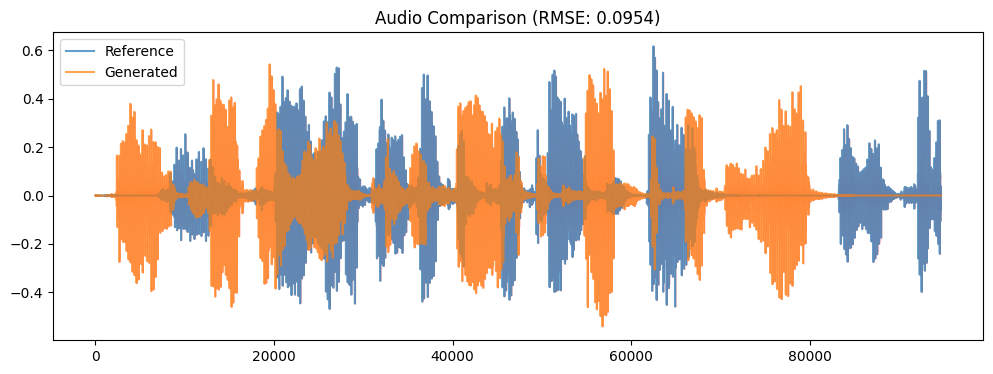

RMSE: 0.0954


In [86]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def calculate_rmse(reference_audio, generated_audio, sr=24000):
    # Load audio if paths are provided
    if isinstance(reference_audio, str):
        reference_audio, _ = librosa.load(reference_audio, sr=sr)
    if isinstance(generated_audio, str):
        generated_audio, _ = librosa.load(generated_audio, sr=sr)

    # Convert to mono if needed
    if len(reference_audio.shape) > 1:
        reference_audio = np.mean(reference_audio, axis=0)
    if len(generated_audio.shape) > 1:
        generated_audio = np.mean(generated_audio, axis=0)

    # Trim to same length
    min_length = min(len(reference_audio), len(generated_audio))
    ref_trimmed = reference_audio[:min_length]
    gen_trimmed = generated_audio[:min_length]

    # Calculate RMSE
    rmse = np.sqrt(np.mean((ref_trimmed - gen_trimmed) ** 2))
    plt.figure(figsize=(12, 4))
    plt.plot(ref_trimmed, label='Reference', alpha=0.7)
    plt.plot(gen_trimmed, label='Generated', alpha=0.7)
    plt.fill_between(np.arange(min_length), ref_trimmed, gen_trimmed, color='red', alpha=0.3)
    plt.title(f"Audio Comparison (RMSE: {rmse_score:.4f})")
    plt.legend()
    plt.show()
    return rmse

rmse_score = calculate_rmse("/content/en_speaker_6.wav", "/content/output.wav")
print(f"RMSE: {rmse_score:.4f}")